Installing/Upgrading required libraries...
Libraries installed.

Ensure your Colab runtime is set to GPU:
Go to 'Runtime' -> 'Change runtime type' -> Select 'GPU' for 'Hardware accelerator' -> Click 'Save'.
Then restart the runtime (Runtime -> Restart runtime) and run all cells again.

Unzipping Flickr8k_2k.zip to /content/...
Unzipping complete.
Images will be loaded from: /content/Flicker8k_2kDataset

Loading BLIP model and processor...
Model loaded successfully.

Generating captions for sample images from the dataset...

Image: 3223224391_be50bf4f43.jpg
Generated Caption: a dog running in the snow


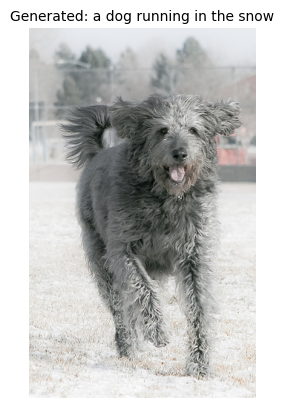


Image: 3182161610_4d349b257f.jpg
Generated Caption: a child sitting in a play area


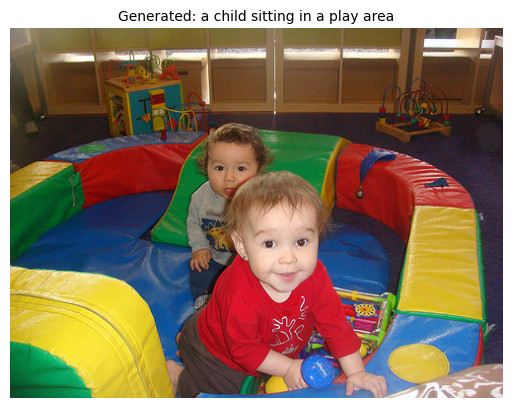


Image: 341665272_80d4d61376.jpg
Generated Caption: a dog running in the snow with a fr frc


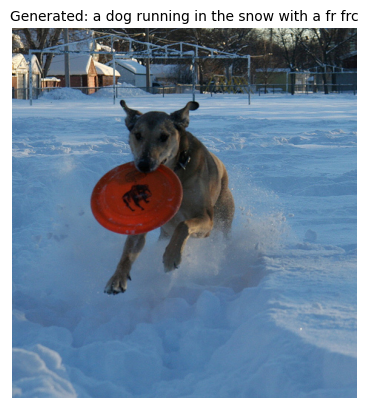


Image: 3112635165_2d614d7c1a.jpg
Generated Caption: a dog laying on the ground


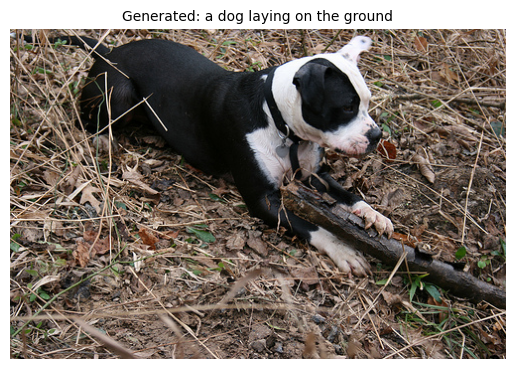


Image: 3225310099_d8e419ba56.jpg
Generated Caption: a boat is lifted by a crane as the sun sets over the ocean


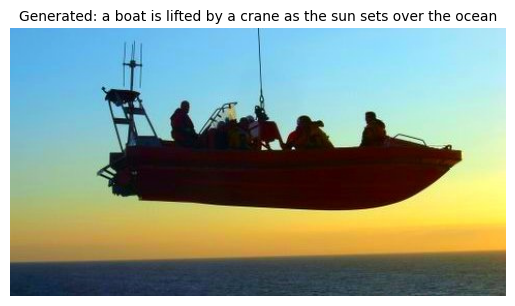


--- VLM test completed successfully! ---


In [ ]:
import os # For interacting with the operating system, like file paths
from PIL import Image # For opening and manipulating images
from transformers import BlipProcessor, BlipForConditionalGeneration # Hugging Face libraries for the BLIP model
import matplotlib.pyplot as plt # For displaying images
import matplotlib.image as mpimg # For reading images as NumPy arrays
import random # For selecting random images
import zipfile # Essential for handling .zip files

# --- 0. Colab Setup (Run these cells sequentially in Colab) ---

# Cell 1: Install/Upgrade necessary libraries
print("Installing/Upgrading required libraries...")
# Using '!' to execute shell commands in Colab
!pip install transformers --upgrade # Upgrade the transformers library
!pip install torch torchvision torchaudio --upgrade # Upgrade PyTorch and its related libraries
!pip install matplotlib # Install matplotlib for plotting and image display
print("Libraries installed.")

# Cell 2: Set Runtime to GPU (VERY IMPORTANT!)
# This is a guiding message. You must perform this action manually via the Colab menu:
# Go to 'Runtime' -> 'Change runtime type' -> Select 'GPU' for 'Hardware accelerator' -> Click 'Save'.
# Colab will prompt you to restart the runtime. Confirm and restart.
# After restarting, run all cells again from the beginning (e.g., by pressing Ctrl+M A).
print("\nEnsure your Colab runtime is set to GPU:")
print("Go to 'Runtime' -> 'Change runtime type' -> Select 'GPU' for 'Hardware accelerator' -> Click 'Save'.")
print("Then restart the runtime (Runtime -> Restart runtime) and run all cells again.")


# Cell 3: Unzip your dataset
# Based on your provided image, the exact name of your zip file is 'Flickr8k_2k.zip'.
dataset_zip_name = 'Flickr8k_2k.zip' # <--- VERIFY THIS NAME!

# The base path where the dataset will be unzipped in Colab.
extracted_data_base_path = '/content/'

# The final path to the folder containing your actual image files.
# Based on your image, inside the zip, there's a folder named 'Flicker8k_2kDataset' (note the spelling).
images_dir_in_colab = os.path.join(extracted_data_base_path, 'Flicker8k_2kDataset') # <--- IMPORTANT: Corrected spelling to 'Flicker'

# Check if the zip file exists and then unzip it
zip_file_full_path = os.path.join(extracted_data_base_path, dataset_zip_name)
if os.path.exists(zip_file_full_path): # If the zip file exists at the specified path:
    print(f"\nUnzipping {dataset_zip_name} to {extracted_data_base_path}...")
    # 'r' is for read mode of the zip file.
    # .extractall() extracts all contents of the zip file to the specified path.
    with zipfile.ZipFile(zip_file_full_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_data_base_path)
    print("Unzipping complete.")
else: # If the zip file is not found:
    print(f"Error: ZIP file '{dataset_zip_name}' not found at '{extracted_data_base_path}'.")
    print("Please ensure you have correctly uploaded your .zip file to Colab session storage and its name is exact.")
    exit() # Stop the program.

# Verify that the image directory exists after unzipping
if not os.path.exists(images_dir_in_colab): # If the expected image folder is not found:
    print(f"Error: Expected image directory '{images_dir_in_colab}' not found after unzipping.")
    print("Please check the internal structure of your .zip file again.")
    print("It should contain a folder named 'Flicker8k_2kDataset' with images inside.")
    # For debugging, you can uncomment the line below to list the contents of /content/:
    # !ls -F /content/
    exit()
else: # If the image folder is found:
    print(f"Images will be loaded from: {images_dir_in_colab}")


# --- 1. Set Dataset Paths for Colab (pointing to the extracted location) ---
# This variable now points to the actual directory containing your images.
images_dir = images_dir_in_colab


# --- 2. Load the VLM Model (BLIP) ---
print("\nLoading BLIP model and processor...")
# BlipProcessor: Used for image preprocessing and text tokenization.
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# BlipForConditionalGeneration: This is the actual Vision-Language Model (VLM) used for caption generation.
# .to("cuda") moves the model to the GPU memory. This significantly speeds up inference, as Colab provides GPU access.
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")
print("Model loaded successfully.")

# --- 3. Image Caption Generation Function ---
def generate_caption(image_path):
    """
    Generates a text caption for a given image using the loaded BLIP model.
    """
    try:
        # Open the image and convert it to RGB format (ensures compatibility with the model).
        raw_image = Image.open(image_path).convert("RGB")

        # Process the image and prepare it for the model.
        # .to("cuda") ensures the input tensors are also on the GPU.
        inputs = processor(raw_image, return_tensors="pt").to("cuda")

        # Generate the caption using the model.
        # The generate method handles the entire text generation process.
        outputs = model.generate(**inputs)

        # Decode the model's output (which are token IDs) into human-readable text.
        # skip_special_tokens=True removes special tokens like [CLS], [SEP].
        caption = processor.decode(outputs[0], skip_special_tokens=True)
        return caption
    except Exception as e: # Catch any errors during image processing
        return f"Error processing image {image_path}: {e}"

print("\nGenerating captions for sample images from the dataset...")

# --- 4. Select and Process Sample Images ---
# Get a list of all image files (jpg, jpeg, png) in the specified directory.
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if len(image_files) == 0: # If no image files are found:
    print("No image files found in the dataset directory. Please check the folder structure.")
    print(f"Ensure image files are directly inside '{images_dir}'.")
    exit() # Stop the program.

# Select a few random images to display (e.g., 5 images).
num_samples_to_show = min(5, len(image_files)) # Ensure we don't try to pick more than available images.
selected_sample_images = random.sample(image_files, num_samples_to_show)

for img_file in selected_sample_images: # For each selected image:
    image_path = os.path.join(images_dir, img_file) # Construct the full path to the image.
    caption = generate_caption(image_path) # Generate a caption using the function.

    print(f"\nImage: {img_file}")
    print(f"Generated Caption: {caption}")

    # Display the image and its generated caption using matplotlib
    plt.imshow(mpimg.imread(image_path)) # Read and display the image.
    plt.title(f"Generated: {caption}", fontsize=10) # Set the plot title to the generated caption.
    plt.axis('off') # Hide axes for a cleaner image display.
    plt.show() # Display the plot window.

print("\n--- VLM test completed successfully! ---")